# District Mapping
This notebook is for taking lat,long info from raw data and looking up the correct council district ID. The raw data has incorrect council codes, and this notebook rectifies that. See also `util.py` for a script version of this notebook in the root folder. 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import util

In [2]:
df_lats = pd.read_csv('../data/2020_Building_Energy_Benchmarking.csv')
df_lats = gp.GeoDataFrame(df_lats, geometry=gp.points_from_xy(df_lats.Longitude, df_lats.Latitude))
df_districts = gp.read_file("../data/Council_Districts.geojson")
df_lats.head()

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
0,1,2020,MAYFLOWER PARK HOTEL,NonResidential,0659000030,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,...,801392,1457837,6326,Compliant,No Issue,2734351.0,632586.0,169.1,1.9,POINT (-122.33799 47.61220)
1,2,2020,PARAMOUNT HOTEL,NonResidential,0659000220,724 PINE ST,SEATTLE,WA,98101.0,47.61317,...,568667,0,16614,Compliant,No Issue,1940292.0,1661402.0,98.6,1.1,POINT (-122.33393 47.61317)
2,3,2020,WESTIN HOTEL (Parent Building),NonResidential,0659000475,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,...,7478716,10359896,8955,Compliant,No Issue,25517379.0,895500.0,1043.2,1.4,POINT (-122.33822 47.61367)
3,5,2020,HOTEL MAX,NonResidential,0659000640,620 STEWART ST,SEATTLE,WA,98101.0,47.61412,...,345231,917724,8871,Compliant,No Issue,1177927.0,887059.0,129.6,2.1,POINT (-122.33664 47.61412)
4,8,2020,WARWICK SEATTLE HOTEL,NonResidential,0659000970,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,...,1102452,0,46034,Compliant,No Issue,3761566.0,4603411.0,264.5,2.3,POINT (-122.34047 47.61375)


In [111]:
df_lats[['BuildingName','Neighborhood', 'Latitude', 'Longitude','geometry']].head()

,BuildingName,Neighborhood,Latitude,Longitude,geometry
0,MAYFLOWER PARK HOTEL,DOWNTOWN,47.61220,-122.33799,POINT (-122.33799 47.61220)
1,PARAMOUNT HOTEL,DOWNTOWN,47.61317,-122.33393,POINT (-122.33393 47.61317)
2,WESTIN HOTEL (Parent Building),DOWNTOWN,47.61367,-122.33822,POINT (-122.33822 47.61367)
3,HOTEL MAX,DOWNTOWN,47.61412,-122.33664,POINT (-122.33664 47.61412)
4,WARWICK SEATTLE HOTEL,DOWNTOWN,47.61375,-122.34047,POINT (-122.34047 47.61375)


In [112]:
df_districts

,OBJECTID,C_DISTRICT,AREA_ACRES,AREA_SQMI,DISPLAY_NAME,SHAPE_Length,SHAPE_Area,geometry
0,1,4,6126.1,9.57,CD - 4,124238.010052,2.668503e+08,"MULTIPOLYGON (((-122.27113 47.69269, -122.2712..."
1,2,3,5310.9,8.30,CD - 3,110756.978635,2.313440e+08,"MULTIPOLYGON (((-122.32124 47.65231, -122.3212..."
2,3,1,10252.4,16.02,CD - 1,154856.114891,4.465917e+08,"MULTIPOLYGON (((-122.38710 47.59523, -122.3871..."
3,4,2,11072.7,17.30,CD - 2,170319.145123,4.823260e+08,"POLYGON ((-122.32766 47.60172, -122.32879 47.6..."
4,5,6,6389.0,9.98,CD - 6,92234.633397,2.783048e+08,"MULTIPOLYGON (((-122.37080 47.70849, -122.3695..."
5,6,5,8255.3,12.90,CD - 5,92855.768194,3.595996e+08,"POLYGON ((-122.35917 47.73414, -122.36093 47.7..."
6,7,7,6100.4,9.53,CD - 7,125106.963222,2.657319e+08,"MULTIPOLYGON (((-122.40893 47.67149, -122.4089..."


In [182]:
# Some points I've already figured out, usually because they're on the water. 
# Might be better to use addresses
known_updates = {
    'WATERWORKS OFFICE & MARINA': 7, 
    'WATERWORKS OFFICES + MARINA': 7, 
    'NAUTICAL LANDING':7,
    'UNION HARBOR CONDOMINIUM':4,
    'THE PIER AT LESCHI':3,
    'PIER AT LESCHI THE':3
}
# Go through all of the building and lookup their (long, lat) to update what district they're in. 
# Outliers are left with a -1 district code and examined manually later. 
def clean_districts(df):
    for idx, row in df.iterrows():
        point = row['geometry']
        district = -1 # Flag an unkonwn district
        for gidx, grow in df_districts.iterrows():
            if(grow['geometry'].intersects(point)): 
                district = grow['C_DISTRICT']
                #print(f"Building {row.BuildingName} {idx} in district {district}")
        if(district < 0):
            #df.at[idx, 'CouncilDistrictCode'] = -1
            print( f"Building {row.BuildingName} {idx} doesn't have a district {row.geometry}")
            if(row.BuildingName.upper() in known_updates.keys()):
                district = known_updates[row.BuildingName.upper()]
                print(f"\t Found district {district} for {row.BuildingName}")
        df.at[idx, 'CouncilDistrictCode'] = district

In [189]:
# Plot the district boundaries and building (long, lat) points color-coded by the predicted districts. 
# Extra dark points have a district of -1. 
def plot_points(df):
    ax = df_districts['geometry'].plot()
    df['geometry'].plot(ax=ax, c=df.CouncilDistrictCode, markersize=10)

In [126]:
# Looks like buildings on the water don't get bound into the districts. 
# Manual lookup in the city district finder yielded results, so it's a product of the lookup method. 
df_lats.loc[df_lats["Neighborhood"]=="water"]

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
2353,25464,2020,WATERWORKS OFFICE & MARINA,NonResidential,4088803975,1818 WESTLAKE AVE N,SEATTLE,WA,98109.0,47.63575,...,638431,0,21406,Compliant,No Issue,2178328.0,2140595.0,125.3,4.1,POINT (-122.33895 47.63575)
2381,25563,2020,NAUTICAL LANDING,NonResidential,4088804350,2500 WESTLAKE AVE N,SEATTLE,WA,98109.0,47.64306,...,617715,0,9410,Not Compliant,Default Data,2107642.0,940951.0,61.2,2.1,POINT (-122.34219 47.64306)
2540,26138,2020,UNION HARBOR CONDOMINIUM,Multifamily MR (5-9),8807200000,2301 FAIRVIEW AVE E,SEATTLE,WA,98102.0,47.64010,...,395213,0,0,Compliant,No Issue,1348465.0,0.0,7.2,0.1,POINT (-122.33003 47.64010)
2997,27951,2020,THE PIER AT LESCHI,Multifamily LR (1-4),6780900000,334 LAKESIDE AVE S,SEATTLE,WA,98144.0,47.59926,...,203380,0,0,Compliant,No Issue,693931.0,0.0,3.7,0.2,POINT (-122.28563 47.59926)


In [127]:
# Two other points don't have a valid address. Fixed manually. 
df_lats.loc[df_lats['geometry'].is_empty==True]

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
3046,29069,2020,THE LAKESHORE,Multifamily LR (1-4),1180001715,11448 RAINIER AVE S,SEATTLE,WA,98178.0,NaN,...,1042353,0,19490,Compliant,No Issue,3556508.0,1948964.0,122.4,1.0,POINT EMPTY
3218,49911,2020,EDUCARE,NonResidential,2895800030,625 SW 100TH ST,SEATTLE,WA,98146.0,NaN,...,238581,0,5529,Compliant,No Issue,814038.0,552949.0,33.7,0.8,POINT EMPTY


In [128]:
df_lats.at[2353, 'CouncilDistrictCode'] = 7 # WATERWORKS OFFICE & MARINA
df_lats.at[2381, 'CouncilDistrictCode'] = 7 # NAUTICAL LANDING
df_lats.at[2540, 'CouncilDistrictCode'] = 4 # UNION HARBOR CONDOMINIUM
df_lats.at[2997, 'CouncilDistrictCode'] = 3 # THE PIER AT LESCHI
# Drop the lakeshore- not in seattle city limits according to manual verification
# Drop educare- not in seattle city limits according to manual verification
f

<AxesSubplot: >

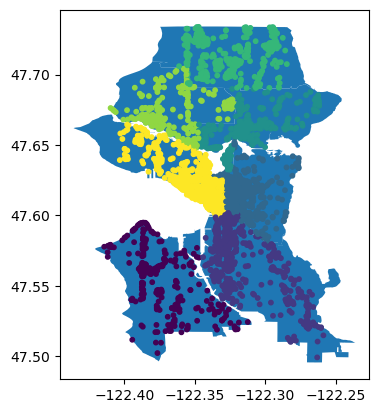

In [129]:
ax = df_districts['geometry'].plot()
df_lats['geometry'].plot(ax=ax, c=df_lats.CouncilDistrictCode, markersize=10)

In [123]:
df_lats.to_csv("2020_Building_Energy_Benchmarking_FIXED.csv")

# 2019 Data
- Pretty clean already, all of the unclean points were the same as 2020. 

In [6]:
# Rename 2017& earlier PropertyName to BuildingName
# 2015 doesn't have latlong
year = 2019
df_building = pd.read_csv(f'{year}_Building_Energy_Benchmarking.csv')
if('PropertyName' in df_building.columns):
    df_building= df_building.rename(columns={'PropertyName':'BuildingName'})
df_lats = gp.GeoDataFrame(df_building, geometry=gp.points_from_xy(df_building.Longitude, df_building.Latitude))
clean_districts(df_lats)
plot_points(df_lats)

# Same two dropped values as 2020 dataset
df_lats = df_lats.drop(df_lats[df_lats['geometry'].is_empty==True].index)
df_lats.to_csv(f"{year}_Building_Energy_Benchmarking_FIXED.csv")

NameError: name 'clean_districts' is not defined

# 2017 Data
- Loads of missing district codes around Broadway. Seems to need some manual verification of if they land in D3 or D2. If anyone has a better way of automating this lookup process, I'm all ears. 

c:\Users\linne\miniconda3\envs\bps\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Building INScape 487 doesn't have a district POINT EMPTY
Building Silver Cloud Inn - Broadway 627 doesn't have a district POINT EMPTY
Building Brix Condominium 918 doesn't have a district POINT EMPTY
Building Pacific Northwest Research 1261 doesn't have a district POINT EMPTY
Building Japanese Baptist Church 1382 doesn't have a district POINT EMPTY
Building Cal Anderson House 1386 doesn't have a district POINT EMPTY
Building Hollywood Lofts 2107 doesn't have a district POINT EMPTY
Building All Pilgrims Christian Church 2357 doesn't have a district POINT EMPTY
Building Waterworks Offices + Marina 2401 doesn't have a district POINT (-122.33895 47.63575)
	 Found district 7 for Waterworks Offices + Marina
Building Nautical Landing 2429 doesn't have a district POINT (-122.34219 47.64306)
	 Found district 7 for Nautical Landing
Building Capitol Building 2502 doesn't have a district POINT EMPTY
Building Union Harbor 2589 doesn't have a district POINT (-122.33003 47.6401)
Building 700 Broadway

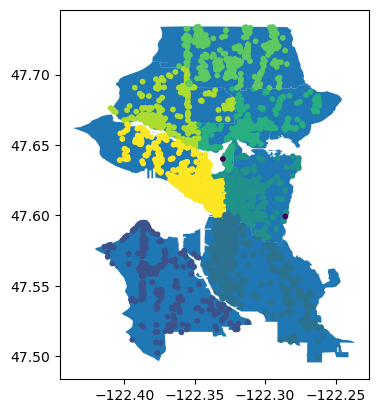

In [183]:
year = 2017
df_building = pd.read_csv(f'{year}_Building_Energy_Benchmarking.csv')
if('PropertyName' in df_building.columns):
    df_building= df_building.rename(columns={'PropertyName':'BuildingName'})
df_lats = gp.GeoDataFrame(df_building, geometry=gp.points_from_xy(df_building.Longitude, df_building.Latitude))
clean_districts(df_lats)
plot_points(df_lats)

In [184]:
df_lats[df_lats.CouncilDistrictCode==-1][['BuildingName','Neighborhood', 'Address', 'geometry']]

,BuildingName,Neighborhood,Address,geometry
487,INScape,NaN,815 Seattle Blvd S.,POINT EMPTY
627,Silver Cloud Inn - Broadway,NaN,1100 Broadway,POINT EMPTY
918,Brix Condominium,NaN,530 Broadway Ave E,POINT EMPTY
1261,Pacific Northwest Research,NaN,720 Broadway,POINT EMPTY
1382,Japanese Baptist Church,NaN,160 Broadway,POINT EMPTY
1386,Cal Anderson House,NaN,400 Broadway,POINT EMPTY
2107,Hollywood Lofts,NaN,127 Broadway Ave E,POINT EMPTY
2357,All Pilgrims Christian Church,NaN,500 Broadway E,POINT EMPTY
2502,Capitol Building,NaN,906 E John St,POINT EMPTY
2589,Union Harbor,water,2301 Fairview Ave E,POINT (-122.33003 47.64010)


In [186]:
df_lats.at[2589, 'CounilDistrictsCode'] = 4 # Union Harbor	
df_lats.at[3056, 'CounilDistrictsCode'] = 3 # The Pier at Leschi Condominium Owners Association	

df_lats.at[487, 'CounilDistrictsCode'] = 2 # INScape	
df_lats.at[627, 'CounilDistrictsCode'] = 3 # Silver Cloud Inn - Broadway	
df_lats.at[918, 'CounilDistrictsCode'] = 3 # Brix Condominium
# And more. I got tired. 

# 2015 Data
No lat/long data so my current system doesn't apply. :( Options include to use existing scraping techniques to go from address --> district code, or find a way to go from address --> lat, long. 

In [188]:
year = 2015
df_building = pd.read_csv(f'{year}_Building_Energy_Benchmarking.csv')
if('PropertyName' in df_building.columns):
    df_building= df_building.rename(columns={'PropertyName':'BuildingName'})
df_building.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,BuildingName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
0,21548,2015,Multifamily LR (1-4),Low-Rise Multifamily,PUGET VISTA APTS,1992200030,"411 W REPUBLICAN ST\nSEATTLE, WA 98119\n(47.62...",7,MAGNOLIA / QUEEN ANNE,1967,...,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not Compliant,NaN
1,26379,2015,NonResidential,Hotel,GEORGETOWN INN,6920700025,"6100 CORSON AVE S\nSEATTLE, WA 98108\n(47.5477...",2,GREATER DUWAMISH,1992,...,589893.0,7644.0,764350.0,0.0,44.71,1.88,No,NaN,Compliant,NaN
2,26713,2015,Multifamily HR (10+),High-Rise Multifamily,QUINTESSA APTS,5247800955,"201 YESLER WAY\nSEATTLE, WA 98104\n(47.6015502...",7,DOWNTOWN,2007,...,2829904.0,15320.0,1531968.0,0.0,101.09,0.98,No,NaN,Compliant,NaN
3,102,2015,NonResidential,Hotel,MARRIOTT RESIDENCE INN,1984200065,"800 FAIRVIEW AVE N\nSEATTLE, WA 98109\n(47.626...",3,LAKE UNION,1990,...,10638785.0,81908.0,8190794.0,0.0,509.18,1.64,No,NaN,Compliant,NaN
4,503,2015,NonResidential,Supermarket/Grocery Store,RESTAURANT DEPOT,1824049003,"3670 E MARGINAL WAY S\nSEATTLE, WA 98134\n(47....",2,GREATER DUWAMISH,2008,...,6620217.0,0.0,0.0,0.0,46.15,0.28,No,NaN,Compliant,NaN


In [5]:
year=2020
df_2020 = pd.read_csv(f'{year}_Building_Energy_Benchmarking.csv')
df_2020 = gp.GeoDataFrame(df_2020, geometry=gp.points_from_xy(df_2020.Longitude, df_2020.Latitude))
clean_districts(df_2020)

year=2019
df_2019 = pd.read_csv(f'{year}_Building_Energy_Benchmarking.csv')
df_2019 = gp.GeoDataFrame(df_2019, geometry=gp.points_from_xy(df_2019.Longitude, df_2019.Latitude))
clean_districts(df_2019)

NameError: name 'clean_districts' is not defined